In [1]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm

import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader

from trainer import Trainer
from conv_tasnet import ConvTasNet

In [2]:
with open("train.yml", mode='r') as f:
    opt = yaml.load(f,Loader=yaml.FullLoader)

with open("test.yml", mode='r') as f:
    test_opt = yaml.load(f,Loader=yaml.FullLoader)

# Dataset

In [3]:
class ConvTasNetMixDataset(Dataset):
    def __init__(self, root_dir: str, split: str ='train', max_len: int = -1, sample_rate: int = 8000):
        """
        Args:
            root_dir (str): Path to the base folder containing 'train', 'valid', 'test' directories.
            split (str): One of ['train', 'valid', 'test']
            sample_rate (int): Sampling rate for loading audio
            segment (float or None): Duration of segment to crop (in seconds), or None for full audio
        """
        self.mix_dir = os.path.join(root_dir, split, 'mix')
        self.s1_dir = os.path.join(root_dir, split, 's1')
        self.s2_dir = os.path.join(root_dir, split, 's2')
        self.sample_rate = sample_rate

        self.filenames = sorted(os.listdir(self.mix_dir))
        if max_len != -1:
            self.filenames = self.filenames[:max_len]
        assert all(os.path.exists(os.path.join(self.s1_dir, f.replace("mix", "s1"))) for f in self.filenames), "Missing s1 files"
        assert all(os.path.exists(os.path.join(self.s2_dir, f.replace("mix", "s2"))) for f in self.filenames), "Missing s2 files"


    def __len__(self):
        return len(self.filenames)


    def __getitem__(self, idx):
        mix_path = os.path.join(self.mix_dir, self.filenames[idx])
        s1_path = os.path.join(self.s1_dir, self.filenames[idx].replace("mix", "s1"))
        s2_path = os.path.join(self.s2_dir, self.filenames[idx].replace("mix", "s2"))

        mix, mix_sr = torchaudio.load(mix_path)
        if mix_sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(mix_sr, self.sample_rate)
            mix = resampler(mix)

        s1, s1_sr = torchaudio.load(s1_path)
        if s1_sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(s1_sr, self.sample_rate)
            s1 = resampler(s1)
    
        s2, s2_sr = torchaudio.load(s2_path)
        if s2_sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(s2_sr, self.sample_rate)
            s2 = resampler(s2)

        mix = mix.mean(dim=0)
        s1 = s1.mean(dim=0)
        s2 = s2.mean(dim=0)

        return {
            "mix": mix, 
            "ref": [s1, s2]
        }

In [4]:
train_set = ConvTasNetMixDataset(root_dir="mix_dataset", split="train", sample_rate=8000)
val_set   = ConvTasNetMixDataset(root_dir="mix_dataset", split="valid", sample_rate=8000)

In [5]:
train_loader = DataLoader(train_set, batch_size=3, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=4)

# Modeling

In [6]:
model = ConvTasNet(**opt['net_conf']).to('cuda')
trainer = Trainer(model, **opt['train'], resume=opt['resume'], optimizer_kwargs=opt['optimizer_kwargs'])

2025-05-18 12:06:59 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:171 - INFO ] Create optimizer adam: {'lr': 0.001, 'weight_decay': 1e-05}
/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-05-18 12:06:59 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:139 - INFO ] Starting preparing model ............
2025-05-18 12:06:59 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:140 - INFO ] Loading model to GPUs:(0,), #param: 3.48M
2025-05-18 12:06:59 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:145 - INFO ] Gradient clipping by 200, default L2


2025-05-18 01:52:13 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:210 - INFO ] Validation model ......
2025-05-18 01:52:34 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:229 - INFO ] <epoch:  0, lr:1.000e-03, loss:26.069, Total time:0.351 min> 
2025-05-18 01:52:34 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:242 - INFO ] Starting epoch from 0, loss = 26.0695
2025-05-18 01:52:34 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:179 - INFO ] Training model ......
2025-05-18 01:53:36 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:197 - INFO ] <epoch:  1, iter:200, lr:1.000e-03, loss:1.019, batch:200 utterances> 
2025-05-18 01:54:37 [/home/artur/files/Audio Processing/Audio_Processing_Labs/Paper_review/trainer.py:197 - INFO ] <epoch:  1, iter:400, lr:1.000e-03, loss:0.241, batch:400 utterances> 
2025-05-18 01:55:39 [/

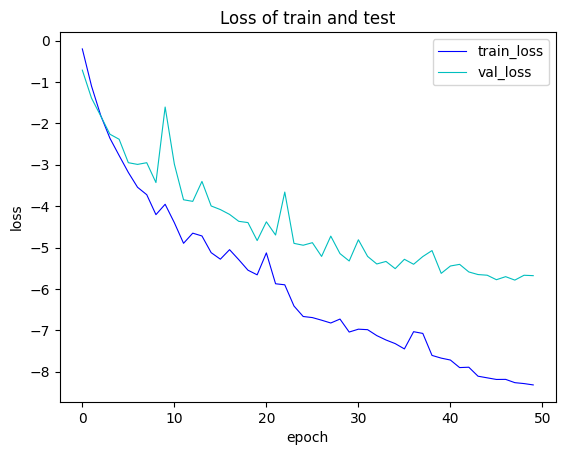

In [7]:
trainer.run(train_loader, val_loader)

# Testing

In [6]:
weights = torch.load("./Conv-TasNet-checkpoints/best.pt")
model = ConvTasNet(**test_opt['net_conf'])
model.load_state_dict(weights["model_state_dict"])

<All keys matched successfully>

In [7]:
model

ConvTasNet(
  (encoder): Conv1D(1, 512, kernel_size=(16,), stride=(8,))
  (LayerN_S): CumulativeLayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (BottleN_S): Conv1D(512, 128, kernel_size=(1,), stride=(1,))
  (separation): Sequential(
    (0): Sequential(
      (0): Conv1D_Block(
        (conv1x1): Conv1D(128, 512, kernel_size=(1,), stride=(1,))
        (PReLU_1): PReLU(num_parameters=1)
        (norm_1): GlobalLayerNorm()
        (dwconv): Conv1D(512, 512, kernel_size=(3,), stride=(1,), padding=(1,), groups=512)
        (PReLU_2): PReLU(num_parameters=1)
        (norm_2): GlobalLayerNorm()
        (Sc_conv): Conv1d(512, 128, kernel_size=(1,), stride=(1,))
      )
      (1): Conv1D_Block(
        (conv1x1): Conv1D(128, 512, kernel_size=(1,), stride=(1,))
        (PReLU_1): PReLU(num_parameters=1)
        (norm_1): GlobalLayerNorm()
        (dwconv): Conv1D(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), groups=512)
        (PReLU_2): PReLU(num_parameters=1)


In [8]:
test_set  = ConvTasNetMixDataset(root_dir="mix_dataset", split="test", sample_rate=8000)
test_loader = DataLoader(test_set, batch_size=1)

In [9]:
trainer = Trainer(model, inference=True)

In [10]:
sisnr, sdri = trainer.eval(test_loader)

100%|██████████| 1000/1000 [00:50<00:00, 19.89it/s]


In [18]:
print(f"SI-SNRi: {sisnr:.2f}dB")
print(f"SDRi:    {sdri:.2f}dB")

SI-SNRi: 7.35dB
SDRi:    6.08dB
